In [1]:
from paretoCardinalityRestaurants import *

import shutil
import matplotlib as mpl

# Enable LaTeX rendering if available (fallback to Matplotlib text otherwise)
if shutil.which("latex"):
    mpl.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "text.latex.preamble": r"\usepackage{amsmath}\usepackage{amssymb}",
    })
else:
    mpl.rcParams.update({"text.usetex": False})

In [2]:
def findApproximateParetoSolutionsRestaurants(simMatrix, item_ids, sample_size=None, num_runs=10, k_max=50, dataset_name=""):
    '''
    Run algorithms over multiple runs and plot mean +/- std (Objective vs Cardinality).
    Parameters:
    - simMatrix: Similarity matrix
    - item_ids: List of item ids (restaurants)
    - sample_size: Optional subsample size for items
    - num_runs: Number of independent runs
    - k_max: Maximum cardinality
    - dataset_name: Name of the dataset for plotting
    '''
    algo_names = ["ParetoGreedy-Cardinality", "TopK", "Random"]

    # Subsample items if requested
    n_items = len(item_ids)
    if sample_size is None or sample_size <= 0 or sample_size >= n_items:
        selected_indices = np.arange(n_items)
    else:
        rng = np.random.default_rng()
        selected_indices = rng.choice(n_items, size=sample_size, replace=False)
    selected_indices = np.sort(selected_indices)
    sub_items = [item_ids[i] for i in selected_indices]
    sub_sim = simMatrix[np.ix_(selected_indices, selected_indices)]

    # containers across runs
    all_objectives = {alg: [] for alg in algo_names}
    all_runtimes = {alg: [] for alg in algo_names}

    for _ in range(num_runs):
        run_objectives = {alg: [] for alg in algo_names}
        run_runtimes = {alg: [] for alg in algo_names}

        # Pareto Greedy (Cardinality)
        pareto = paretoCardinalityRestaurants(n_items=sub_items, simMatrix=sub_sim, k_max=k_max)
        _, _, _, runTime = pareto.paretoGreedy()
        objectives = [pareto.kSolDict.get(k, {'Objective': 0})['Objective'] for k in range(1, k_max + 1)]
        run_objectives['ParetoGreedy-Cardinality'] = objectives
        run_runtimes['ParetoGreedy-Cardinality'] = runTime

        # Top K
        pareto2 = paretoCardinalityRestaurants(n_items=sub_items, simMatrix=sub_sim, k_max=k_max)
        _, _, _, runTime = pareto2.top_k()
        objectives = [pareto2.kSolDict.get(k, {'Objective': 0})['Objective'] for k in range(1, k_max + 1)]
        run_objectives['TopK'] = objectives
        run_runtimes['TopK'] = runTime

        # Random
        pareto3 = paretoCardinalityRestaurants(n_items=sub_items, simMatrix=sub_sim, k_max=k_max)
        _, _, _, runTime = pareto3.random_selection()
        objectives = [pareto3.kSolDict.get(k, {'Objective': 0})['Objective'] for k in range(1, k_max + 1)]
        run_objectives['Random'] = objectives
        run_runtimes['Random'] = runTime

        # store per-run arrays and total runtimes
        for alg in algo_names:
            arr = np.array(run_objectives[alg], dtype=float)
            if arr.size == 0:
                arr = np.zeros(k_max, dtype=float)
            all_objectives[alg].append(arr)
            all_runtimes[alg].append(run_runtimes[alg])

    # compute mean and std across runs for each algorithm
    mean_objectives = {}
    std_objectives = {}
    for alg in algo_names:
        stacked = np.vstack(all_objectives[alg])  # shape (num_runs, k_max)
        mean_objectives[alg] = np.mean(stacked, axis=0)
        std_objectives[alg] = np.std(stacked, axis=0) * 0.5

    # Plot mean objective with shaded std band
    colors = plt.get_cmap("tab10").colors
    linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]
    markers = ['o', 's', '^', 'v', 'D']
    fig, ax = plt.subplots(figsize=(9, 5.5))
    for i, alg in enumerate(algo_names):
        mean = mean_objectives[alg]
        std = std_objectives[alg]
        is_pareto = alg in {"ParetoGreedy-Cardinality"}
        marker_size = 7 if is_pareto else 6
        line_style = '-' if is_pareto else ':'
        color = colors[i]
        marker = markers[i % len(markers)]
        zorder = 3
        if alg == "ParetoGreedy-Cardinality":
            color = colors[3]
            marker = "D"
            zorder = 4
        label = rf"\texttt{{{alg}}} (ours)" if is_pareto else rf"\texttt{{{alg}}}"
        ax.plot(range(1, k_max + 1), mean, label=label, color=color, linestyle=line_style, marker=marker, markersize=marker_size, markeredgewidth=1.1, markeredgecolor='k', linewidth=1.8, zorder=zorder)
        ax.fill_between(range(1, k_max + 1), np.clip(mean - std, 0, None), mean + std, color=color, alpha=0.18, zorder=2)
    
    ax.set_xlabel(r'Cardinality, $k$', fontsize=28)
    ax.set_ylabel(r'Objective, $\bar{f}$', fontsize=28)
    ax.set_title("")
    ax.grid(alpha=0.3)
    ax.tick_params(axis='both', labelsize=24)
    
    # Legend handles (saved separately)
    handles, labels = ax.get_legend_handles_labels()
    
    # Save figure
    from pathlib import Path
    base_dir = Path.cwd().resolve().parents[1]
    plots_dir = base_dir / "plots" / "cardinality"
    plots_dir.mkdir(parents=True, exist_ok=True)
    safe_name = (dataset_name or "dataset").replace(" ", "_")
    out_path = plots_dir / f"{safe_name}_cardinality.pdf"
    fig.savefig(out_path, bbox_inches="tight")
    
    # Save legend as separate PDF
    if handles:
        legend_out_path = plots_dir / "cardinality_legend.pdf"
        if not legend_out_path.exists():
            legend_fig = plt.figure(figsize=(8, 2))
            legend_fig.legend(handles, labels, loc='center', ncol=3, fontsize=22, frameon=True)
            legend_fig.savefig(legend_out_path, bbox_inches="tight")
            plt.close(legend_fig)
    
    plt.show()
    
    # Runtime summary (mean ± std)
    runtime_lines = ["Runtime summary (mean ± std, seconds):"]
    for alg in algo_names:
        mean_rt = float(np.mean(all_runtimes[alg])) if len(all_runtimes[alg]) > 0 else 0.0
        std_rt = float(np.std(all_runtimes[alg])) if len(all_runtimes[alg]) > 0 else 0.0
        runtime_lines.append(f"  - {alg}: {mean_rt:.3f} ± {std_rt:.3f}")
    logging.info("\n".join(runtime_lines))
    
    return None

### Yelp Phoenix Experiments

In [3]:
#Import Yelp Phoenix dataset
data_path = '../../datasets/pickled_data/yelp/yelp_phoenix_'
    
#Import pickled data
with open(data_path + 'ids.pkl', "rb") as fp:
    phoenix_ids = pickle.load(fp)

with open(data_path + 'sim.pkl', "rb") as fp:
    phoenix_simMatrix = pickle.load(fp)

2026-02-01 14:33:59,974 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:300, k_max=50
2026-02-01 14:34:01,796 |INFO: Cardinality Greedy Solution:[81, 141, 106, 28, 157, 257, 216, 283, 16, 92, 213, 179, 191, 82, 76, 145, 37, 46, 153, 27, 249, 91, 13, 201, 4, 39, 193, 110, 59, 268, 60, 290, 189, 183, 50, 192, 149, 130, 260, 150, 70, 112, 137, 143, 80, 134, 68, 111, 279, 299], Objective:109.054, Runtime = 1.82 seconds
2026-02-01 14:34:01,797 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:300, k_max=50
2026-02-01 14:34:02,096 |INFO: Top-k Solution:[81, 28, 191, 152, 157, 114, 91, 200, 234, 37, 24, 276, 107, 82, 274, 249, 209, 225, 136, 54, 38, 151, 9, 48, 44, 222, 228, 145, 236, 129, 149, 165, 172, 4, 283, 223, 29, 19, 141, 118, 153, 62, 229, 121, 213, 166, 87, 108, 226, 76], Objective:85.699, Runtime = 0.30 seconds
2026-02-01 14:34:02,097 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:3

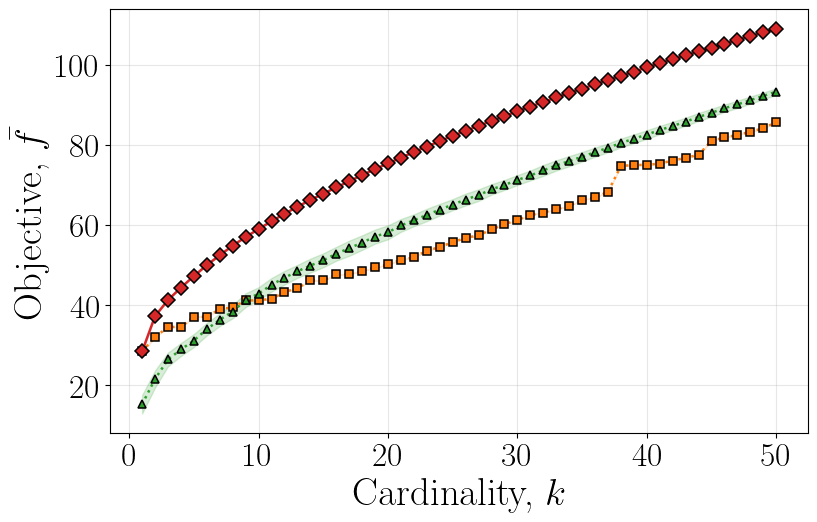

2026-02-01 14:34:32,915 |INFO: Runtime summary (mean ± std, seconds):
  - ParetoGreedy-Cardinality: 1.679 ± 0.062
  - TopK: 0.314 ± 0.025
  - Random: 0.149 ± 0.014


In [4]:
# Adjust parameters as needed
sample_size = 300
num_runs = 15  # number of random runs
k_max = 50
findApproximateParetoSolutionsRestaurants(phoenix_simMatrix, phoenix_ids, sample_size, num_runs, k_max, "Yelp_Phoenix")

### Yelp Vegas Experiments

In [5]:
#Import Yelp Vegas dataset
data_path = '../../datasets/pickled_data/yelp/yelp_vegas_'
    
#Import pickled data
with open(data_path + 'ids.pkl', "rb") as fp:
    vegas_ids = pickle.load(fp)

with open(data_path + 'sim.pkl', "rb") as fp:
    vegas_simMatrix = pickle.load(fp)

2026-02-01 14:34:32,970 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:500, k_max=50
2026-02-01 14:34:36,989 |INFO: Cardinality Greedy Solution:[62, 155, 64, 298, 286, 134, 276, 163, 156, 420, 192, 438, 303, 412, 77, 26, 147, 198, 310, 223, 282, 148, 352, 299, 333, 30, 224, 154, 378, 442, 391, 127, 372, 170, 376, 331, 218, 214, 152, 293, 209, 415, 95, 260, 85, 28, 359, 264, 389, 31], Objective:150.626, Runtime = 4.02 seconds
2026-02-01 14:34:36,989 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:500, k_max=50
2026-02-01 14:34:37,543 |INFO: Top-k Solution:[62, 310, 306, 160, 326, 282, 295, 93, 473, 152, 299, 259, 64, 71, 46, 175, 274, 26, 12, 88, 20, 197, 28, 346, 266, 155, 485, 342, 263, 405, 286, 31, 40, 163, 221, 56, 233, 466, 243, 18, 292, 372, 101, 177, 389, 32, 300, 162, 412, 381], Objective:107.801, Runtime = 0.55 seconds
2026-02-01 14:34:37,544 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Insta

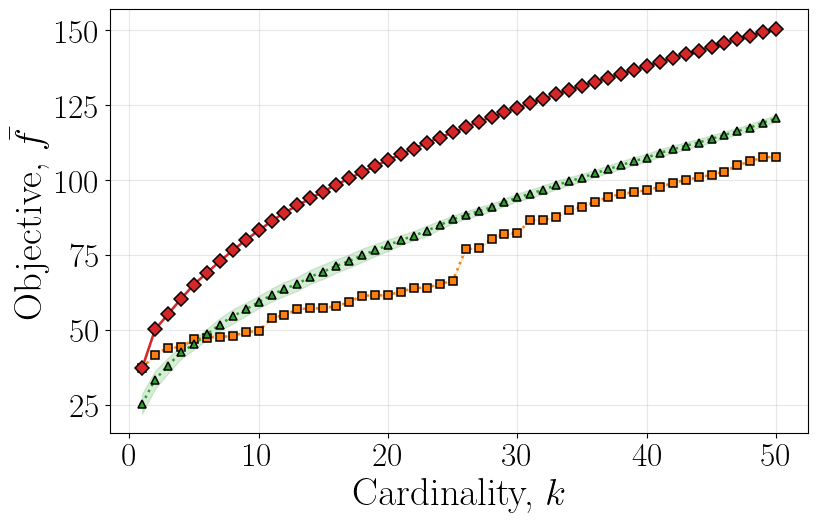

2026-02-01 14:35:44,914 |INFO: Runtime summary (mean ± std, seconds):
  - ParetoGreedy-Cardinality: 3.957 ± 0.086
  - TopK: 0.556 ± 0.029
  - Random: 0.258 ± 0.022


In [6]:
# Adjust parameters as needed
sample_size = 500
num_runs = 15  # number of random runs
k_max = 50
findApproximateParetoSolutionsRestaurants(vegas_simMatrix, vegas_ids, sample_size, num_runs, k_max, "Yelp_Vegas")